<a href="https://colab.research.google.com/github/smlacava/Themis/blob/main/CV_dataset_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3DMM-based 3D face reconstruction
Demo of a 3D face reconstruction based on a 3DMM (3D Morphological Model) from a single RGB image.

# Initial settings



## Automatic settings

*   Import and installation of the libraries used
*   Downloading useful files and repositories

In [ ]:
!git clone https://github.com/patrikhuber/eos
!git clone https://github.com/smlacava/Themis/
!unzip Themis/Frontal.zip
!wget dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2
!wget dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bunzip2 shape_predictor_5_face_landmarks.dat.bz2

!pip install eos-py

Cloning into 'eos'...
remote: Enumerating objects: 9018, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 9018 (delta 9), reused 16 (delta 4), pack-reused 8991
Receiving objects: 100% (9018/9018), 13.90 MiB | 28.36 MiB/s, done.
Resolving deltas: 100% (5775/5775), done.
Cloning into 'Themis'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
Archive:  Themis/Frontal.zip
   creating: Frontal/001/
  inflating: Frontal/001/001_01_01_051_07_crop_128.png  
   creating: Frontal/002/
  inflating: Frontal/002/002_01_01_051_07_crop_128.png  
   creating: Frontal/003/
  inflating: Frontal/003/003_01_01_051_07_crop_128.png  
   creating: Frontal/004/
  inflating: Frontal/004/004_01_01_051_07_crop_128.png  
   creating: Frontal/005/
  inflating: Frontal/005/

In [ ]:
import numpy as np
import dlib
import eos
import cv2
import pandas as pd
from google.colab import files
import io
import os
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [ ]:
detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

model = eos.morphablemodel.load_model("eos/share/sfm_shape_3448.bin")
blendshapes = eos.morphablemodel.load_blendshapes("eos/share/expression_blendshapes_3448.bin")
morphablemodel_with_expressions = eos.morphablemodel.MorphableModel(
    model.get_shape_model(), 
    blendshapes,
    color_model=eos.morphablemodel.PcaModel(),
    vertex_definitions=None,
    texture_coordinates=model.get_texture_coordinates()
)

landmark_mapper = eos.core.LandmarkMapper('eos/share/ibug_to_sfm.txt')
edge_topology = eos.morphablemodel.load_edge_topology('eos/share/sfm_3448_edge_topology.json')
contour_landmarks = eos.fitting.ContourLandmarks.load('eos/share/ibug_to_sfm.txt')
model_contour = eos.fitting.ModelContour.load('eos/share/sfm_model_contours.json')

# Isomap interpolation

In [ ]:
def _check_colors(img, r_idx, c_idx):
  """
  This function checks if the considered pixel corresponds to an unrendered part
  of the image.

  Input:
   img:   is the 3D image (RGB, BRG, RGBA, or BRGA) which has to be checked
   r_idx: is the index correspoding to the y-coordinate
   c_idx: is the index corresponding to the x-coordinate

  Output:
   Check: is a boolean value corresponding to True if the pixel was rendered,
          False otherwise
  """
  return not(img[r_idx, c_idx, 0] == 255 and img[r_idx, c_idx, 1] == 255 and img[r_idx, c_idx, 2] == 255)# and img[r_idx, c_idx, 3]==0)


def _proportions(isomap, rows, columns):
  """
  This function returns the area between the eyes and the mouth, using as
  minimum y coordinate and minimum and maximum x coordinates the center of the 
  eyes, while as maximum y coordinate the center of the mouth, through the 
  golden facial proportions.

  Input:
   isomap:  is the isomap containing the facial texture
   rows:    is the dimension of the isomap in terms of rows (i.e., height)
   columns: is the dimension of the isomap in terms of columns (i.e., width)

  Output:
   x_min:   is an integer corresponding to the minimum x coordinate
   x_max:   is an integer corresponding to the maximum x coordinate
   y_min:   is an integer corresponding to the minimum y coordinate
   y_max:   is an integer corresponding to the maximum y coordinate 
  """
  # Face proportions for eyes center from: 
  # Kaya, K. S., Türk, B., Cankaya, M., Seyhun, N., & Coşkun, B. U. (2019). 
  # Assessment of facial analysis measurements by golden proportion. 
  # Brazilian journal of otorhinolaryngology, 85, 494-501.
  y_min = int(np.floor(rows*0.333)) 
  x_min = int(np.floor(columns*0.3))
  x_max = columns-x_min

  # Face proportions for mouth center from: 
  # Kaya, K. S., Türk, B., Cankaya, M., Seyhun, N., & Coşkun, B. U. (2019). 
  # Assessment of facial analysis measurements by golden proportion. 
  # Brazilian journal of otorhinolaryngology, 85, 494-501.
  y_max = int(np.floor(columns*0.8143))

  return x_min, x_max, y_min, y_max


def _haar_detector(isomap, rows, columns):
  """
  This function returns the area between the eyes and the mouth, using as
  minimum and maximum x coordinates the lateral edges of the eyes, as minimum y
  coordinate the lower edge of the eyes, while as maximum y coordinate the upper
  edge of the mouth, through Haar Cascade Classifiers for the identification of 
  the eyes and the mouth.

  Input:
   isomap:  is the isomap containing the facial texture
   rows:    is the dimension of the isomap in terms of rows (i.e., height)
   columns: is the dimension of the isomap in terms of columns (i.e., width)

  Output:
   x_min:   is an integer corresponding to the minimum x coordinate
   x_max:   is an integer corresponding to the maximum x coordinate
   y_min:   is an integer corresponding to the minimum y coordinate
   y_max:   is an integer corresponding to the maximum y coordinate 
  """
  try:
    gray = cv2.cvtColor(isomap, cv2.COLOR_BGR2GRAY)
    eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_eye.xml')
    eyes =  eyes_cascade.detectMultiScale(gray, 1.3, 5)
    (x_min, y_min, w, h) = eyes[0]
    (aux_x, aux_y, aux_w, _) = eyes[1]
    if x_min > aux_x:
      x_max = x_min+w
      x_min = aux_x
    else:
      x_max = aux_x+aux_w
    if y_min > aux_y:
      y_min = aux_y
    smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_smile.xml')
    smile =  smile_cascade.detectMultiScale(gray, 1.7, 11)
    (_, y_max, _, _) = smile[-1]
    return x_min, x_max, y_min, y_max
  except:
    return -1, -1, -1, -1


def _landmark_detector(isomap, rows, columns):
  """
  This function returns the area between the eyes and the mouth, using as
  minimum y coordinate and minimum and maximum x coordinates the center of the 
  eyes, while as maximum y coordinate the center of the mouth, through shape
  prediction based on 5 facial landmarks (i.e., eyes, nose, and mouth angles).

  Input:
   isomap:  is the isomap containing the facial texture
   rows:    is the dimension of the isomap in terms of rows (i.e., height)
   columns: is the dimension of the isomap in terms of columns (i.e., width)

  Output:
   x_min:   is an integer corresponding to the minimum x coordinate
   x_max:   is an integer corresponding to the maximum x coordinate
   y_min:   is an integer corresponding to the minimum y coordinate
   y_max:   is an integer corresponding to the maximum y coordinate 
  """
  try:
    box = dlib.rectangle(0, 0, columns, rows)
    simple_shape_predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')
    shape = simple_shape_predictor(cv2.cvtColor(isomap ,cv2.COLOR_BGR2RGB), box)
    index = 1
    landmarks = []
    x_max = 0
    y_max = 0
    x_min = columns
    y_min = rows
    for i in range(shape.num_parts):
      if shape.part(i).x > x_max:
        x_max = shape.part(i).x
      elif shape.part(i).x < x_min:
        x_min = shape.part(i).x
      if shape.part(i).y > y_max:
        y_max = shape.part(i).y
      elif shape.part(i).y < y_min:
        y_min = shape.part(i).y
    return x_min, x_max, y_min, y_max
  except:
    return -1, -1, -1, -1


def _interpolate(img, r, c, rows, columns, channel, left_half=True):
  """
  This function interpolates the unrendered pixel either through directional
  local interpolation.

  Input:
   img:
   r:         is the y-index of the pixel which has to be interpolated
   c:         is the x-index of the pixel which has to be interpolated
   rows:      is the total number of rows of the image (i.e., height)
   columns:   is the total number of columns of the image (i.e., width)
   channel:   is the index of the considered color channel
   left_half: is a Boolean value which has to be True if the pixel belongs to
              the left half of the face, for using the local interpolation
              direction from left to right, False otherwise, for using the 
              opposite direction (True by default)

  Output:
   px:        is the interpolated value of the pixel
  """
  if left_half is True:
    int_r = r-2
    int_c = c-2
    delta_r = r-3
    delta_c = c-3
  else:
    int_r = r+2
    int_c = c+2
    delta_r = r+3
    delta_c = c+3
  return img[int_r, int_c, channel]*2-img[delta_r, delta_c, channel]


def isomap_interpolation(isomap):
  """
  This function interpolates the eventually unrendered values of the isomap, 
  focusing the search on the area near the nose.

  Input:
   isomap:     is the texture of the 3D face
  
  Output:
   new_isomap: is the isomap with interpolated values in correspondence to the
               unrendered parts
  """
  aux = copy.deepcopy(isomap)
  (rows, columns, channels) = aux.shape
  half_c = int(np.floor(columns/2))

  funs = [_landmark_detector, _haar_detector, _proportions]
  funs_names = ["Landmark", "Haar", "Proportions"]
  x_min = -1
  count = 0
  while x_min == -1:
    x_min, x_max, y_min, y_max = funs[count](aux, rows, columns)
    count += 1
  print(funs_names[count-1]+": x = ["+ str(x_min)+","+str(x_max)+"]; y = ["+ str(y_min)+","+str(y_max)+"]")

  y_range = range(y_min, y_max)
  for c in range(x_min, half_c):
    for r in y_range:
      if _check_colors(aux, r, c) is False:
        aux[r, c, 0] = _interpolate(aux, r, c, rows, columns, 0, True)
        aux[r, c, 1] = _interpolate(aux, r, c, rows, columns, 1, True)
        aux[r, c, 2] = _interpolate(aux, r, c, rows, columns, 2, True)

  for c in reversed(range(half_c, x_max)):
    for r in y_range:
      if _check_colors(aux, r, c) is False:
        aux[r, c, 0] = _interpolate(aux, r, c, rows, columns, 0, False)
        aux[r, c, 1] = _interpolate(aux, r, c, rows, columns, 1, False)
        aux[r, c, 2] = _interpolate(aux, r, c, rows, columns, 2, False)
  return aux

## Reconstruction of a single face


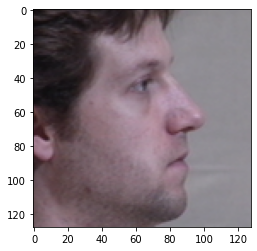

In [ ]:
mainDir = "Frontal"
subDirs = os.listdir(mainDir)
sd = subDirs.index('001') #043
files = os.listdir(mainDir+"/"+subDirs[sd])
img = cv2.imread(mainDir+"/"+subDirs[sd]+"/"+files[0])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [ ]:
box = detector(img)
lp = []
shape = shape_predictor(img, box[0])
index = 1
landmarks = []
for i in range(shape.num_parts):
    landmarks.append(eos.core.Landmark(str(index),[shape.part(i).x, shape.part(i).y]))
    index +=1

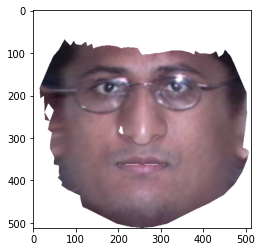

Landmark: x = [150,368]; y = [184,321]


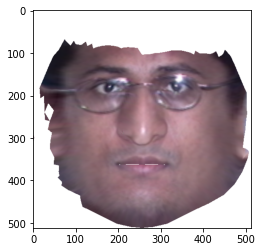

In [ ]:
h,w = img.shape[:2]
landmark_ids = list(map(str, range(1, 69)))
canvas = img.copy()
mesh, pose, shape_coeffs, blendshape_coeffs = eos.fitting.fit_shape_and_pose(
    morphablemodel_with_expressions, landmarks, landmark_mapper, w, h, 
    edge_topology, contour_landmarks, model_contour)
isomap = eos.render.extract_texture(mesh, pose, 
                                    cv2.cvtColor(canvas, cv2.COLOR_RGB2RGBA))
plt.imshow(cv2.cvtColor(isomap ,cv2.COLOR_BGR2RGB))
plt.show()
int_isomap = isomap_interpolation(isomap)
plt.imshow(cv2.cvtColor(int_isomap ,cv2.COLOR_BGR2RGB))
plt.show()

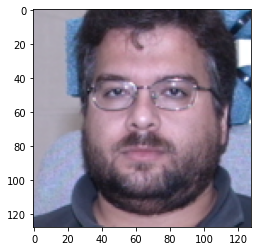

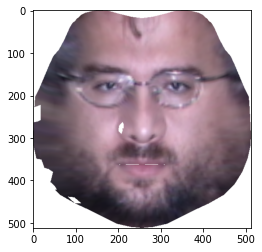

Landmark: x = [153,363]; y = [182,312]


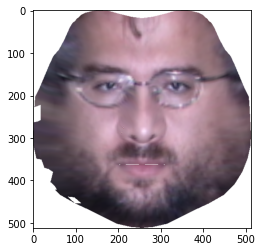

In [ ]:
mainDir = "Frontal"
subDirs = os.listdir(mainDir)
sd = subDirs.index('023')
files = os.listdir(mainDir+"/"+subDirs[sd])
img = cv2.imread(mainDir+"/"+subDirs[sd]+"/"+files[0])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

box = detector(img)
lp = []
shape = shape_predictor(img, box[0])
index = 1
landmarks = []
for i in range(shape.num_parts):
    landmarks.append(eos.core.Landmark(str(index),[shape.part(i).x, shape.part(i).y]))
    index +=1

h,w = img.shape[:2]
landmark_ids = list(map(str, range(1, 69)))
canvas = img.copy()
mesh, pose, shape_coeffs, blendshape_coeffs = eos.fitting.fit_shape_and_pose(
    morphablemodel_with_expressions, landmarks, landmark_mapper, w, h, 
    edge_topology, contour_landmarks, model_contour)
isomap = eos.render.extract_texture(mesh, pose, 
                                    cv2.cvtColor(canvas, cv2.COLOR_RGB2RGBA))
plt.imshow(cv2.cvtColor(isomap ,cv2.COLOR_BGR2RGB))
plt.show()
int_isomap = isomap_interpolation(isomap)
plt.imshow(cv2.cvtColor(int_isomap ,cv2.COLOR_BGR2RGB))
plt.show()

# Reconstruction of the whole dataset


In [ ]:
outDir = "Reconstructed"
os.mkdir(outDir)
mainDir = "Frontal"
subDirs = os.listdir(mainDir)

FileExistsError: ignored

In [ ]:
for sdir in subDirs:
  imgPath = mainDir+"/"+sdir
  files = os.listdir(imgPath)
  img = cv2.imread(imgPath+"/"+files[0])
  fname = sdir

  box = detector(img)
  lp = []
  shape = shape_predictor(img, box[0])
  index = 1
  landmarks = []
  for i in range(shape.num_parts):
    landmarks.append(eos.core.Landmark(str(index),
                                       [shape.part(i).x, shape.part(i).y]))
    index +=1

  h,w = img.shape[:2]
  landmark_ids = list(map(str, range(1, 69)))
  canvas = img.copy()
  mesh, pose, shape_coeffs, blendshape_coeffs = eos.fitting.fit_shape_and_pose(
    morphablemodel_with_expressions, landmarks, landmark_mapper, w, h, 
    edge_topology, contour_landmarks, model_contour)
  
  isomap = eos.render.extract_texture(mesh, pose, 
                                      cv2.cvtColor(canvas, cv2.COLOR_RGB2RGBA))
  int_isomap = isomap_interpolation(isomap)

  texture_file = outDir+"/"+fname+".texture.png"
  shape_file = outDir+"/"+fname+".obj"
  mtl_file = outDir+"/"+fname+".mtl"
  eos.core.write_textured_obj(mesh, shape_file)
  cv2.imwrite(texture_file, int_isomap)

Landmark: x = [142,365]; y = [183,319]
Landmark: x = [145,363]; y = [185,317]
Landmark: x = [152,358]; y = [180,315]
Landmark: x = [147,361]; y = [181,322]
Landmark: x = [150,367]; y = [184,314]
Landmark: x = [145,362]; y = [185,320]
Landmark: x = [144,367]; y = [181,317]
Landmark: x = [144,364]; y = [182,314]
Landmark: x = [144,368]; y = [185,312]
Landmark: x = [149,369]; y = [185,315]
Landmark: x = [140,367]; y = [183,316]
Landmark: x = [150,360]; y = [178,309]
Landmark: x = [146,366]; y = [184,314]
Landmark: x = [140,372]; y = [187,322]
Landmark: x = [149,358]; y = [179,315]
Landmark: x = [147,362]; y = [183,312]
Landmark: x = [147,368]; y = [183,314]
Landmark: x = [150,368]; y = [184,321]
Landmark: x = [142,371]; y = [188,318]
Landmark: x = [148,362]; y = [512,314]
Landmark: x = [146,365]; y = [180,317]
Landmark: x = [143,359]; y = [185,317]
Landmark: x = [146,349]; y = [176,315]
Landmark: x = [151,356]; y = [182,317]
Landmark: x = [147,362]; y = [179,317]
Landmark: x = [141,365]; 

## Download the reconstructed faces

In [ ]:
 !zip -r face_models.zip Reconstructed

  adding: Reconstructed/ (stored 0%)
  adding: Reconstructed/074.obj (deflated 66%)
  adding: Reconstructed/005.mtl (deflated 5%)
  adding: Reconstructed/085.texture.png (deflated 17%)
  adding: Reconstructed/169.mtl (deflated 5%)
  adding: Reconstructed/159.mtl (deflated 5%)
  adding: Reconstructed/215.texture.png (deflated 17%)
  adding: Reconstructed/147.texture.png (deflated 21%)
  adding: Reconstructed/133.texture.png (deflated 12%)
  adding: Reconstructed/139.texture.png (deflated 18%)
  adding: Reconstructed/017.mtl (deflated 5%)
  adding: Reconstructed/240.obj (deflated 66%)
  adding: Reconstructed/001.texture.png (deflated 21%)
  adding: Reconstructed/148.mtl (deflated 5%)
  adding: Reconstructed/199.texture.png (deflated 18%)
  adding: Reconstructed/159.obj (deflated 66%)
  adding: Reconstructed/011.texture.png (deflated 19%)
  adding: Reconstructed/214.obj (deflated 66%)
  adding: Reconstructed/188.mtl (deflated 5%)
  adding: Reconstructed/236.texture.png (deflated 18%)
  ad

In [ ]:
from google.colab import files
files.download("face_models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>